# Binary Knapsack Problem

A knapsack of limited capacity and a set of items are given. Each item has a weight and a profit. The goal is to select a subset of items such that the total profit is maximized and the sum of the weights does not exceed the capacity of the knapsack.

## Data

*I*: Set of items.

*q*: Capacity of knapsack.

*w_i*: weight of item *i ∈ I*.

*p_i*: Profit of item *i ∈ I*.

## Variables

*x_i*: is 1 if item is in the knapsack, 0 otherwise.

## Objective Function

Maximize the profit. z^* = max ∑_(i∈I) p_i * x_i

## Constraints

Do not exceed the knapsack capacity ∑_(i∈I) w_i * x_i <= q

## Model implementation

In [1]:
import pyomo.environ as pyo

model = pyo.AbstractModel()

### Set of Items

In [2]:
# initialization with a list (the initialization does not occur until we call method create_instance()).
model.I = pyo.Set(initialize=list(range(1,11)))

### Parameters

Parameters can be initialized at least in three ways:

- passing a dictionary (or a single value for non-indexed parameters)
- passing a function returning a dictionary (or a single value for non-indexed parameters)
- passing a function taking as argument an index and returning a value

In [3]:
import random
random.seed(42)

def get_profits(model):
    return {i: random.randrange(10, 50) for i in model.I}

def get_weights(model, i):
    return random.randrange(1, 10)

model.q = pyo.Param(initialize=20, mutable=True)
model.p = pyo.Param(model.I, initialize=get_profits)
model.w = pyo.Param(model.I, rule=get_weights)

### Variables

In [4]:
model.x = pyo.Var(model.I, within=pyo.Binary)

### Objective Function

In [5]:
def obj_function(model):
    return sum(model.p[i] * model.x[i] for i in model.I)

model.z = pyo.Objective(rule=obj_function, sense=pyo.maximize)

### Constraints

In [6]:
def cons_capacity(model):
    return sum(model.w[i] * model.x[i] for i in model.I) <= model.q

model.cons_capacity = pyo.Constraint(rule=cons_capacity)

In [7]:
model.pprint()

1 Set Declarations
    I : Size=0, Index=None, Ordered=Insertion
        Not constructed

3 Param Declarations
    p : Size=0, Index=I, Domain=Any, Default=None, Mutable=False
        Not constructed
    q : Size=0, Index=None, Domain=Any, Default=None, Mutable=True
        Not constructed
    w : Size=0, Index=I, Domain=Any, Default=None, Mutable=False
        Not constructed

1 Var Declarations
    x : Size=0, Index=I
        Not constructed

1 Objective Declarations
    z : Size=0, Index=None, Active=True
        Not constructed

1 Constraint Declarations
    cons_capacity : Size=0, Index=None, Active=True
        Not constructed

7 Declarations: I q p w x z cons_capacity


### Solving the Model

First, the elements of the model must be initialized by invoking method create_instance()

In [8]:
instance = model.create_instance()
instance.display()

Model unknown

  Variables:
    x : Size=10, Index=I
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary

  Objectives:
    z : Size=1, Index=None, Active=True
ERROR: evaluating object as numeric value: x[1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[1]
ERROR: evaluating object as numeric value: z
        

In [9]:
solver = pyo.SolverFactory('glpk')
results = solver.solve(instance)
print(results)


Problem: 
- Name: unknown
  Lower bound: 196.0
  Upper bound: 196.0
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 11
  Number of nonzeros: 11
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.022960662841796875
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [10]:
instance.display()

Model unknown

  Variables:
    x : Size=10, Index=I
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   1.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
          6 :     0 :   1.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   1.0 :     1 : False : False : Binary

  Objectives:
    z : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 196.0

  Constraints:
    cons_capacity : Size=1
        Key  : Lower : Body : Upper
        None :  None : 17.0 :    20


In [11]:
print("Knapsack of value {:.1f}".format(pyo.value(instance.z)))
print("x[1] = {:.0f}".format(instance.x[1].value))
print("Selected items: " + ", ".join(str(i) for i, v in instance.x.iteritems() if v.value > 0)  )

Knapsack of value 196.0
x[1] = 0
Selected items: 2, 3, 4, 5, 6, 8, 10


## Parametric analysis

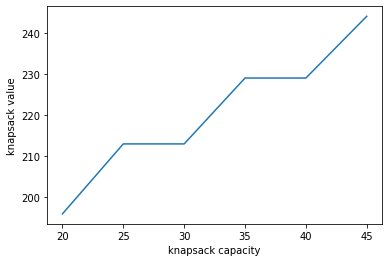

In [12]:
qs = list(range(20, 50, 5))

def parametric_analysis(q):
    instance.q.set_value(q)
    solver.solve(instance)
    return pyo.value(instance.z)

import matplotlib.pyplot as plt
%matplotlib inline

values = list(map(parametric_analysis, qs))
plt.plot(qs, values)
plt.ylabel('knapsack value')
plt.xlabel('knapsack capacity')
plt.show()